# Property Click Prediction
source: https://platform.stratascratch.com/data-projects/property-click-predictionm

In [202]:
import pandas as pd
import numpy as np
import json
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.inspection import PartialDependenceDisplay
from sklearn import set_config
from xgboost import XGBRegressor, plot_importance

set_config(transform_output="pandas")

### (1) Load the data

In [2]:
prop = pd.read_csv("./datasets/property_data_set.csv")
photos = pd.read_csv("./datasets/property_photos.tsv", delimiter="\t")
interaction = pd.read_csv("./datasets/property_interactions.csv")

print(prop.info())
print(photos.info())
print(interaction.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28888 entries, 0 to 28887
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   property_id      28888 non-null  object 
 1   type             28888 non-null  object 
 2   activation_date  28888 non-null  object 
 3   bathroom         28888 non-null  int64  
 4   floor            28888 non-null  int64  
 5   total_floor      28845 non-null  float64
 6   furnishing       28888 non-null  object 
 7   gym              28888 non-null  int64  
 8   latitude         28888 non-null  float64
 9   longitude        28888 non-null  float64
 10  lease_type       28888 non-null  object 
 11  lift             28888 non-null  int64  
 12  locality         28888 non-null  object 
 13  parking          28888 non-null  object 
 14  property_age     28888 non-null  int64  
 15  property_size    28888 non-null  int64  
 16  swimming_pool    28888 non-null  int64  
 17  pin_code    

In [3]:
prop.head()

,property_id,type,activation_date,bathroom,floor,total_floor,furnishing,gym,latitude,longitude,...,lift,locality,parking,property_age,property_size,swimming_pool,pin_code,rent,deposit,building_type
0,ff808081469fd6e20146a5af948000ea,BHK2,09-03-2017 14:36,1,3,4.0,SEMI_FURNISHED,1,12.876174,77.596571,...,1,Hulimavu,BOTH,2,850,1,560076.0,12000,120000,AP
1,ff8080814702d3d10147068359d200cd,BHK2,07-03-2017 12:02,2,4,11.0,SEMI_FURNISHED,1,13.018444,77.678122,...,1,Ramamurthy Nagar,BOTH,1,1233,1,560016.0,20000,150000,AP
2,ff808081470c645401470fb03f5800a6,BHK2,10-03-2017 13:43,2,0,4.0,NOT_FURNISHED,1,12.975072,77.665865,...,1,GM Palya,FOUR_WHEELER,0,1200,0,560075.0,15000,75000,AP
3,ff808081470c6454014715eaa5960281,BHK3,09-03-2017 22:16,2,3,4.0,SEMI_FURNISHED,0,12.888169,77.591282,...,0,Arakere,BOTH,1,1300,0,560076.0,17000,150000,AP
4,ff808081474aa867014771a0298f0aa6,BHK1,15-03-2017 18:29,1,1,2.0,SEMI_FURNISHED,0,12.990243,77.712962,...,0,Hoodi,BOTH,4,450,0,560048.0,6500,40000,IF


In [4]:
photos.head()

,property_id,photo_urls
0,ff808081469fd6e20146a5af948000ea,"[{\title\"":\""Balcony\"",\""name\"":\""IMG_20131006..."
1,ff8080814702d3d10147068359d200cd,NaN
2,ff808081470c645401470fb03f5800a6,"[{\title\"":\""Bedroom\"",\""name\"":\""ff808081470c..."
3,ff808081470c6454014715eaa5960281,"[{\title\"":\""Bedroom\"",\""name\"":\""Screenshot_7..."
4,ff808081474aa867014771a0298f0aa6,"[{\title\"":\""Other\"",\""name\"":\""ff808081474aa8..."


In [5]:
interaction.head()

,property_id,request_date
0,ff808081469fd6e20146a5af948000ea,2017-03-10 17:42:34
1,ff808081469fd6e20146a5af948000ea,2017-03-09 15:51:17
2,ff808081469fd6e20146a5af948000ea,2017-03-10 17:30:22
3,ff808081469fd6e20146a5af948000ea,2017-03-11 17:48:46
4,ff8080814702d3d10147068359d200cd,2017-03-30 19:59:15


### (2) Data manipulation

#### (2.1) Summary of interactions

In [6]:
interaction2 = interaction.merge(
    prop[["property_id", "activation_date"]],
    on="property_id",
    how="left",
    validate="m:1",
    indicator=True,
)
interaction2._merge.value_counts()

_merge
both          170611
left_only          0
right_only         0
Name: count, dtype: int64

In [7]:
interaction2 = interaction2.assign(
    days_since_activation=lambda x: (
        pd.to_datetime(x.request_date, format="%Y-%m-%d %H:%M:%S")
        - pd.to_datetime(x.activation_date, format="%d-%m-%Y %H:%M")
    ).dt.days
)
interaction2.describe()

,days_since_activation
count,170611.000000
mean,12.318326
std,11.201529
min,0.000000
25%,3.000000
50%,9.000000
75%,19.000000
max,67.000000


In [8]:
px.histogram(interaction2, x="days_since_activation", width=800)

Over 75% of requests come in within 21 days of the list activation. The maximum responding time is 67 days.
I choose to model the number of interactions with in 21 days, hence to capturing most of the request.

In [9]:
interaction_grouped = interaction2.groupby("property_id", as_index=False).agg(
    requests_in_21d=("days_since_activation", lambda x: sum(np.where(x <= 21, 1, 0))),
    total_requests=("days_since_activation", "count"),
)

interaction_grouped.head(5)

,property_id,requests_in_21d,total_requests
0,ff808081469fd6e20146a5af948000ea,4,4
1,ff8080814702d3d10147068359d200cd,10,12
2,ff808081470c645401470fb03f5800a6,27,27
3,ff808081470c6454014715eaa5960281,10,13
4,ff808081474aa867014771a0298f0aa6,68,68


Merge back to the property dataset

In [10]:
prop2 = prop.merge(
    interaction_grouped, on="property_id", how="left", validate="1:1", indicator=True
).assign(
    requests_in_21d=lambda x: x.requests_in_21d.fillna(0),
    total_requests=lambda x: x.total_requests.fillna(0),
)

print(prop2._merge.value_counts())


_merge
both          22779
left_only      6109
right_only        0
Name: count, dtype: int64


#### (2.2) Photos data
URL appears to be in JSON format, but the structure is distorted. For example:

(1) '\\' between keys and values, which are not necessary

(2) the first appearance of "title" as a key in the dictionary does not have full paired quotes "" (e.g., \title\")

(3) There is a trailing " at the end of the JSON string

We take steps to fix the distored format and try to identify the proper way to count the number of pictures

In [11]:
photos.head()

,property_id,photo_urls
0,ff808081469fd6e20146a5af948000ea,"[{\title\"":\""Balcony\"",\""name\"":\""IMG_20131006..."
1,ff8080814702d3d10147068359d200cd,NaN
2,ff808081470c645401470fb03f5800a6,"[{\title\"":\""Bedroom\"",\""name\"":\""ff808081470c..."
3,ff808081470c6454014715eaa5960281,"[{\title\"":\""Bedroom\"",\""name\"":\""Screenshot_7..."
4,ff808081474aa867014771a0298f0aa6,"[{\title\"":\""Other\"",\""name\"":\""ff808081474aa8..."


In [12]:
photos2 = photos.dropna().assign(
    # Fix the JSON format
    url_fixed=lambda x: x.photo_urls.str.replace('\\"', '"')
    .str.replace(r']"$', "]", regex=True)
    .str.replace("\\title", '"title'),
    # Convert the JSON to a Python object
    json_payload=lambda x: x.url_fixed.apply(json.loads),
)
# Convert photo2 to JSON
photo2J = json.loads(photos2.to_json(orient="records"))
# Normalize the JSON
normalized = pd.json_normalize(
    photo2J, record_path=["json_payload"], meta=["property_id"]
)

normalized.head()

,title,name,displayPic,imagesMap.original,imagesMap.thumbnail,imagesMap.medium,imagesMap.large,property_id
0,Balcony,IMG_20131006_120837.jpg,False,ff808081469fd6e20146a5af948000ea_65149_origina...,ff808081469fd6e20146a5af948000ea_65149_thumbna...,ff808081469fd6e20146a5af948000ea_65149_medium.jpg,ff808081469fd6e20146a5af948000ea_65149_large.jpg,ff808081469fd6e20146a5af948000ea
1,Bathroom,IMG_20131006_120734.jpg,False,ff808081469fd6e20146a5af948000ea_63511_origina...,ff808081469fd6e20146a5af948000ea_63511_thumbna...,ff808081469fd6e20146a5af948000ea_63511_medium.jpg,ff808081469fd6e20146a5af948000ea_63511_large.jpg,ff808081469fd6e20146a5af948000ea
2,Bedroom,IMG_20131006_120643.jpg,False,ff808081469fd6e20146a5af948000ea_16708_origina...,ff808081469fd6e20146a5af948000ea_16708_thumbna...,ff808081469fd6e20146a5af948000ea_16708_medium.jpg,ff808081469fd6e20146a5af948000ea_16708_large.jpg,ff808081469fd6e20146a5af948000ea
3,Hall,IMG_20131006_120745.jpg,False,ff808081469fd6e20146a5af948000ea_69828_origina...,ff808081469fd6e20146a5af948000ea_69828_thumbna...,ff808081469fd6e20146a5af948000ea_69828_medium.jpg,ff808081469fd6e20146a5af948000ea_69828_large.jpg,ff808081469fd6e20146a5af948000ea
4,Hall,IMG_20131006_120919.jpg,True,ff808081469fd6e20146a5af948000ea_32711_origina...,ff808081469fd6e20146a5af948000ea_32711_thumbna...,ff808081469fd6e20146a5af948000ea_32711_medium.jpg,ff808081469fd6e20146a5af948000ea_32711_large.jpg,ff808081469fd6e20146a5af948000ea


In [13]:
photo_count = (
    normalized.groupby("property_id").agg(photoN=("title", "count")).reset_index()
)

prop3 = (
    prop2.drop("_merge", axis=1)
    .merge(photo_count, on="property_id", how="outer", validate="1:1", indicator=True)
    .assign(photoN=lambda x: x.photoN.fillna(0))
)

prop3._merge.value_counts()

prop3.drop("_merge", axis=1, inplace=True)

### (2.3) Data cleaning and transformation

In [ ]:
catVars = prop3.select_dtypes(include=["object"]).columns.to_list()
numVars = prop3.select_dtypes(include=["int", "float"]).columns.to_list()

In [99]:
prop3.describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

,bathroom,floor,total_floor,gym,latitude,longitude,lift,property_age,property_size,swimming_pool,pin_code,rent,deposit,requests_in_21d,total_requests,photoN
count,28888.000000,28888.000000,28845.000000,28888.000000,28888.000000,28888.000000,28888.000000,28888.000000,28888.000000,28888.000000,2.856300e+04,28888.000000,2.888800e+04,28888.000000,28888.000000,28888.000000
mean,1.789151,1.781155,3.518807,0.165951,12.957859,77.605186,0.279009,4.380539,966.338999,0.142585,5.615600e+05,14430.768797,1.233257e+05,4.689664,5.905947,3.461403
std,0.731346,2.249277,3.362536,0.372043,0.219500,0.921003,0.448520,7.458914,619.390016,0.349655,8.979452e+04,9055.133718,1.255028e+05,7.854677,9.704884,4.230723
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1000.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,1.000000,0.000000,2.000000,0.000000,12.906324,77.563295,0.000000,0.000000,600.000000,0.000000,5.600400e+05,8000.000000,5.000000e+04,0.000000,1.000000,0.000000
50%,2.000000,1.000000,3.000000,0.000000,12.953939,77.614568,0.000000,3.000000,900.000000,0.000000,5.600670e+05,12500.000000,1.000000e+05,2.000000,3.000000,2.000000
75%,2.000000,2.000000,4.000000,0.000000,13.009369,77.669235,1.000000,6.000000,1200.000000,0.000000,5.600840e+05,18000.000000,1.500000e+05,6.000000,7.000000,6.000000
95%,3.000000,5.000000,12.000000,1.000000,13.069919,77.741205,1.000000,15.000000,1815.000000,1.000000,5.601020e+05,30000.000000,3.000000e+05,18.000000,23.000000,11.000000
99%,4.000000,12.000000,19.000000,1.000000,13.120348,77.768832,1.000000,20.000000,2600.000000,1.000000,5.621250e+05,48000.000000,5.213000e+05,37.000000,46.000000,18.000000
max,4.000000,28.000000,38.000000,1.000000,21.176277,80.256293,1.000000,800.000000,40000.000000,1.000000,5.601000e+06,75000.000000,4.200000e+06,169.000000,193.000000,45.000000


In [98]:
prop3 = prop3.assign(
    bathroom=lambda x: x.bathroom.clip(upper=4),
    floor=lambda x: x.floor.clip(upper=x.total_floor),
)

### (3) EDA

In [100]:
prop3.isna().sum()

property_id          0
type                 0
activation_date      0
bathroom             0
floor                0
total_floor         43
furnishing           0
gym                  0
latitude             0
longitude            0
lease_type           0
lift                 0
locality             0
parking              0
property_age         0
property_size        0
swimming_pool        0
pin_code           325
rent                 0
deposit              0
building_type       79
requests_in_21d      0
total_requests       0
photoN               0
dtype: int64

In [25]:
for i in catVars:
    print(f"{i} n={prop3[i].nunique()} {prop3[i].unique()[:10]}")

property_id n=28888 ['ff808081469fd6e20146a5af948000ea' 'ff8080814702d3d10147068359d200cd'
 'ff808081470c645401470fb03f5800a6' 'ff808081470c6454014715eaa5960281'
 'ff808081474aa867014771a0298f0aa6' 'ff8080814780f30801478d14132f03f4'
 'ff8080814780f308014797c79000082e' 'ff80808147a95f0a0147ab0d88fa0080'
 'ff80808147ac6af10147afc279480099' 'ff80808147cbdc2a0147cf8577880153']
type n=6 ['BHK2' 'BHK3' 'BHK1' 'RK1' 'BHK4' 'BHK4PLUS']
activation_date n=18534 ['09-03-2017 14:36' '07-03-2017 12:02' '10-03-2017 13:43'
 '09-03-2017 22:16' '15-03-2017 18:29' '23-03-2017 16:13'
 '06-03-2017 21:30' '05-03-2017 18:12' '07-02-2017 14:05'
 '12-03-2017 11:21']
furnishing n=3 ['SEMI_FURNISHED' 'NOT_FURNISHED' 'FULLY_FURNISHED']
lease_type n=4 ['FAMILY' 'ANYONE' 'BACHELOR' 'COMPANY']
locality n=2368 ['Hulimavu' 'Ramamurthy Nagar' 'GM Palya' 'Arakere' 'Hoodi' 'Banashankari'
 'Koramangala' 'Bennigana Halli' 'Vijayanagar' 'Kundalahalli']
parking n=4 ['BOTH' 'FOUR_WHEELER' 'TWO_WHEELER' 'NONE']
building_type 

Notable correlations:
- Bathroom and rent: 0.65
- Floor and total_floor: 0.74
- Gym and lift: 0.64
- Gym and swimming pool: 0.8
- Property size and rent: 0.62
- rent and deposit: 0.62


In [101]:
# Calculate the correlation matrix
corr_matrix = prop3[numVars].corr()

# Create the heatmap
px.imshow(
    corr_matrix,
    text_auto=".2f",
    color_continuous_scale="Portland",
    width=800,
    height=650,
    title="Correlation Heatmap",
)

In [80]:
numPreds = [
    i
    for i in numVars
    if i
    not in ["latitude", "longitude", "total_requests", "requests_in_21d", "pin_code"]
]
catPreds = [i for i in catVars if i not in ["property_id", "activation_date"]]

allPreds = numPreds + catPreds

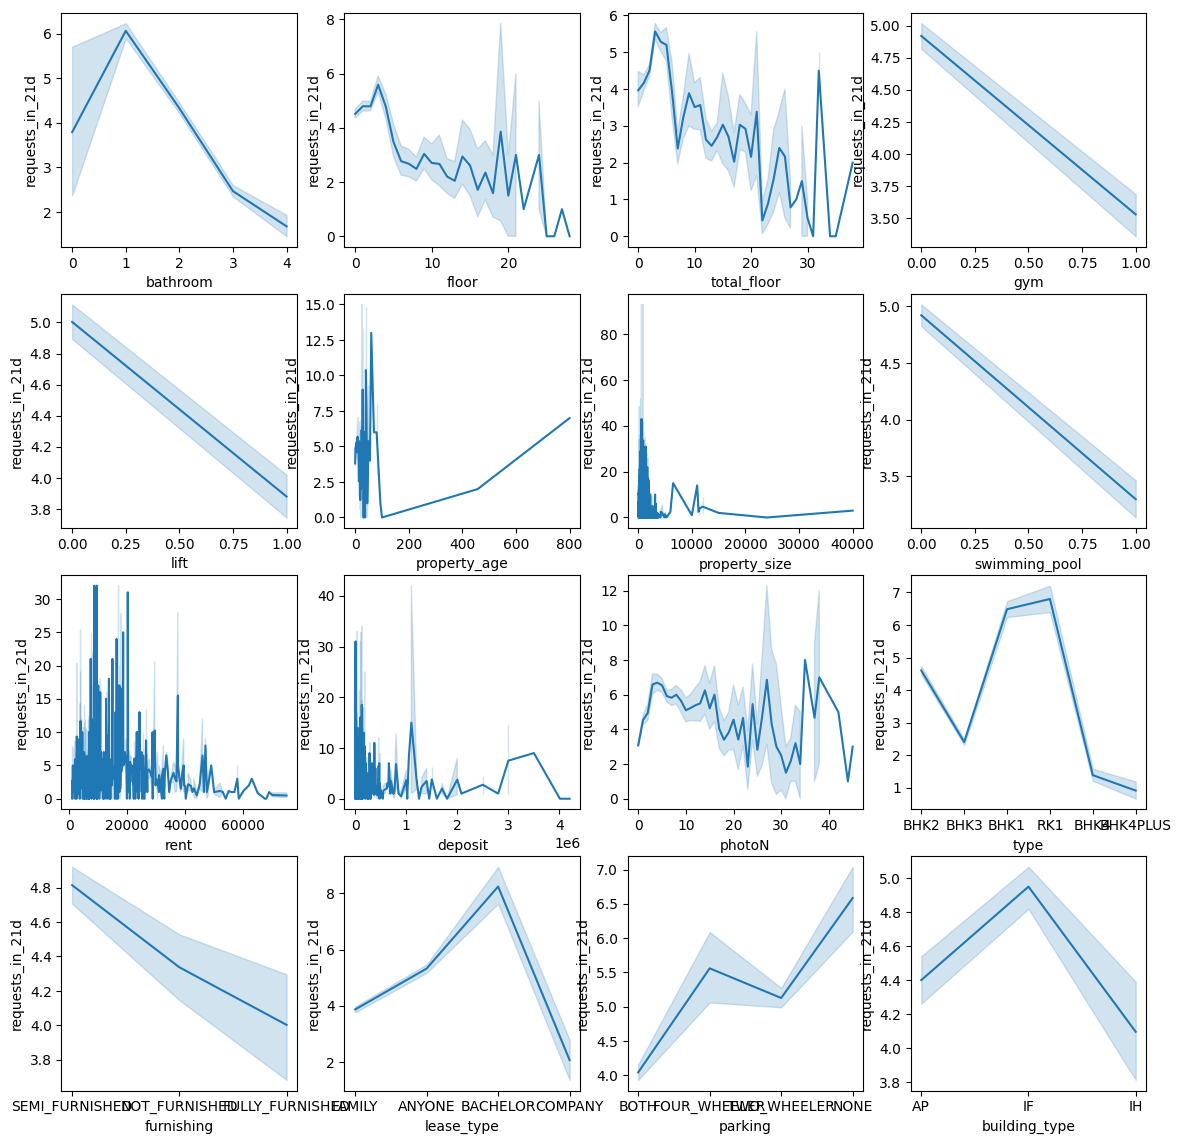

In [104]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(14, 14))
allPreds2 = [i for i in allPreds if i not in ["locality"]]
for i, pred in enumerate(allPreds2):
    sns.lineplot(data=prop3, x=pred, y="requests_in_21d", ax=ax[i // 4, i % 4])

### (4) xgboost

#### (4.1) Data Preprocessing

In [121]:
X = prop3[allPreds]
y = prop3["requests_in_21d"]

print(numPreds)
print(catPreds)

['bathroom', 'floor', 'total_floor', 'gym', 'lift', 'property_age', 'property_size', 'swimming_pool', 'rent', 'deposit', 'photoN']
['type', 'furnishing', 'lease_type', 'locality', 'parking', 'building_type']


In [127]:
catPreds1 = [i for i in catPreds if i not in ["locality"]]
catPreds2 = ["locality"]

colTF = ColumnTransformer(
    [
        ("num", SimpleImputer(strategy="median"), numPreds),
        (
            "cat1",
            OneHotEncoder(drop="first", sparse_output=False),
            catPreds1,
        ),
        (
            "cat2",
            TargetEncoder(target_type="continuous"),
            catPreds2,
        ),
    ]
)

XTF = colTF.fit_transform(X, y)

XTF.head()

,num__bathroom,num__floor,num__total_floor,num__gym,num__lift,num__property_age,num__property_size,num__swimming_pool,num__rent,num__deposit,...,cat1__lease_type_BACHELOR,cat1__lease_type_COMPANY,cat1__lease_type_FAMILY,cat1__parking_FOUR_WHEELER,cat1__parking_NONE,cat1__parking_TWO_WHEELER,cat1__building_type_IF,cat1__building_type_IH,cat1__building_type_nan,cat2__locality
0,1.0,3.0,4.0,1.0,1.0,2.0,850.0,1.0,12000.0,120000.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.587627
1,2.0,4.0,11.0,1.0,1.0,1.0,1233.0,1.0,20000.0,150000.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.814195
2,2.0,0.0,4.0,1.0,1.0,0.0,1200.0,0.0,15000.0,75000.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6.470227
3,2.0,3.0,4.0,0.0,0.0,1.0,1300.0,0.0,17000.0,150000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.621532
4,1.0,1.0,2.0,0.0,0.0,4.0,450.0,0.0,6500.0,40000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.414349


In [146]:
X_train, X_test, y_train, y_test = train_test_split(
    XTF, y, test_size=0.25, random_state=777
)


#### (4.2) Early stopping N CV

In [169]:
set_learning_rate = 0.01

xgbreg = XGBRegressor(
    learning_rate=set_learning_rate,
    n_estimators=2000,
    early_stopping_rounds=100,
    objective="reg:squarederror",
    nthread=-1,
    seed=77,
)

n_fold = 5
y_cut = pd.qcut(y_train, 5, labels=False, duplicates="drop")
kf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=77)
best_iterations = np.zeros(n_fold)

for fold, (learn_index, test_index) in enumerate(kf.split(X_train, y_cut)):
    X_train_fold, X_test_fold = X_train.iloc[learn_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[learn_index], y_train.iloc[test_index]

    xgbreg.fit(
        X_train_fold,
        y_train_fold,
        eval_set=[(X_test_fold, y_test_fold)],
        verbose=0,
    )

    best_iterations[fold] = xgbreg.best_iteration

print(f"{best_iterations=}")
mean_best_iterations = int(np.mean(best_iterations))
print(f"{mean_best_iterations=}")

best_iterations=array([972., 598., 492., 507., 426.])
mean_best_iterations=599


#### (4.3) CV hyperparameter tuning with best iterations

In [178]:
xgbreg2 = XGBRegressor(
    learning_rate=set_learning_rate,
    n_estimators=mean_best_iterations,
    objective="reg:squarederror",
    nthread=-1,
    seed=77,
)

params = {
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 0.9, 1],
    "lambda": [0.1, 0.5, 1],
    "alpha": [0.1, 0.5, 1],
}

xgbGridSearch = GridSearchCV(
    estimator=xgbreg2, param_grid=params, cv=5, verbose=1, n_jobs=-1
)
xgbGridSearch.fit(X_train, y_train)

print(f"{xgbGridSearch.best_params_=}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
xgbGridSearch.best_params_={'alpha': 0.5, 'lambda': 1, 'max_depth': 5, 'subsample': 0.8}


#### (4.4) Model Evaluation

In [195]:
selected_xgb = xgbGridSearch.best_estimator_
y_hat = selected_xgb.predict(X_test)

print(f"Train r2_score: {selected_xgb.score(X_train, y_train):.2f}")
print(f"Test r2_score: {selected_xgb.score(X_test, y_test):.2f}")
px.scatter(x=y_test, y=y_hat, trendline="ols", opacity=0.2, width=600)


Train r2_score: 0.38
Test r2_score: 0.29


#### (4.5) Interpret the model

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

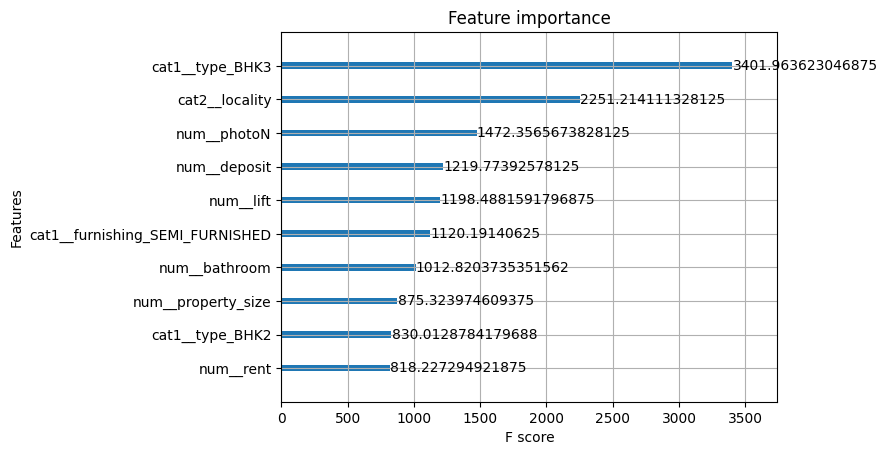

In [200]:
plot_importance(selected_xgb, importance_type="gain", max_num_features=10)

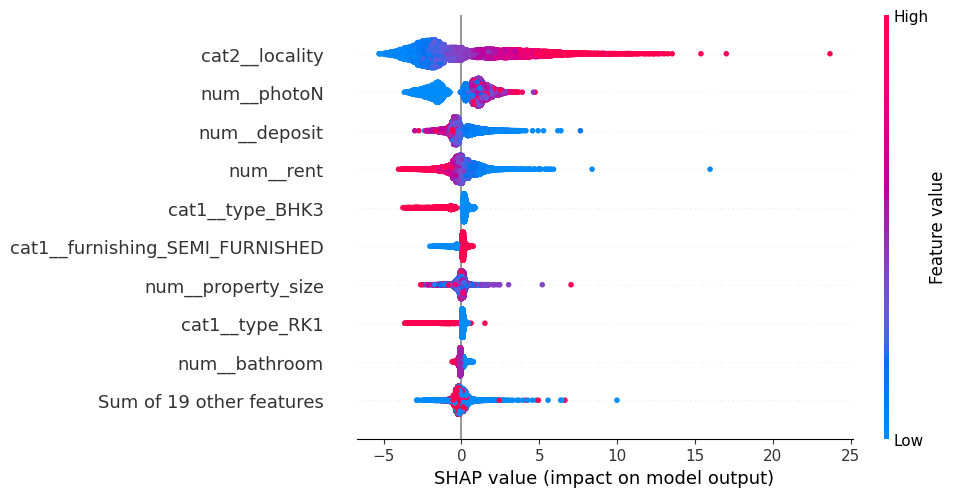

In [196]:
explainer = shap.TreeExplainer(selected_xgb)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values)

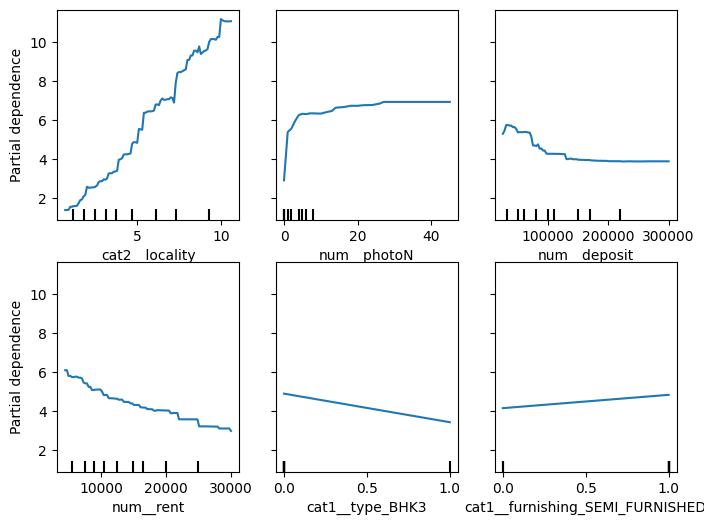

In [207]:
pd = PartialDependenceDisplay.from_estimator(
    selected_xgb,
    X_train,
    features=[
        "cat2__locality",
        "num__photoN",
        "num__deposit",
        "num__rent",
        "cat1__type_BHK3",
        "cat1__furnishing_SEMI_FURNISHED",
    ],
)
pd.figure_.set_size_inches(8, 6)